# Part 4: Automated ML pipeline

MLRun Project is a container for all your work on a particular activity: all of the associated code, functions, 
jobs/workflows and artifacts. Projects can be mapped to `git` repositories, which enable versioning, collaboration, and CI/CD.
Users can create project definitions using the SDK or a yaml file and store those in MLRun DB, file, or archive.
Once the project is loaded you can run jobs/workflows that refer to any project element by name, allowing separation between configuration and code. 

Projects contain `workflows` that execute the registered functions in a sequence/graph (DAG), can reference project 
parameters, secrets and artifacts by name. This notebook demonstrates how to build an automated workflow with 
**feature selection**, **training**, **testing**, and **deployment**. 

<a id="gs-tutorial-4-prerequisites"></a>

## Step 1: Setting up your project

To run a pipeline, you first need to get or create a project object and define/import the required functions for its execution.
See the [**Create, save, and use projects**](../../projects/create-project.html) for details.

The following code gets or creates a user project named "fraud-demo<username>".

In [1]:
# Set the base project name
project_name = 'fraud-demo'

In [2]:
import mlrun

# Initialize the MLRun project object
project = mlrun.get_or_create_project(project_name, context="./", user_project=True)

> 2023-07-13 10:57:24,622 [info] Username was normalized to match the required pattern for project name: {'username': 'PengWei', 'normalized_username': 'pengwei'}
> 2023-07-13 10:57:24,623 [info] Username was normalized to match the required pattern for project name: {'username': 'PengWei', 'normalized_username': 'pengwei'}
> 2023-07-13 10:57:24,737 [info] loaded project fraud-demo from MLRun DB


<a id="gs-tutorial-4-step-import-functions"></a>

## Step 2: Updating project and function definitions

You need to save the definitions for the function you use in the projects. This enables automatically converting code 
to functions or import external functions whenever you load new versions of your code or when you run automated CI/CD 
workflows. In addition, you may want to set other project attributes such as global parameters, secrets, and data.

Your code can be stored in Python files, notebooks, external repositories, packaged containers, etc. You use the 
`project.set_function()` method to register your code in the project. The definitions are saved to the project object, as 
well as in a YAML file in the root of our project.
Functions can also be imported from MLRun marketplace (using the `hub://` schema).

This tutorial uses these functions:
- `feature_selection` &mdash; the first function, which determines the top features to be used for training.
- `train` &mdash; the model-training function
- `evaluate` &mdash; the model-testing function
- `mlrun-model` &mdash; the model-serving function

`set_function` uses the `code_to_function` and `import_function` methods under the hood (used in the previous notebooks), but in addition it saves the function configurations in the project spec for use in automated workflows and CI/CD. 

Add the function definitions to the project along with parameters and data artifacts and save the project.

<a id="gs-tutorial-4-view-project-functions"></a>

In [3]:
project.set_function('hub://feature_selection', 'feature_selection')
project.set_function('hub://auto_trainer','train')
project.set_function('hub://v2_model_server', 'serving')

Names with underscore '_' are about to be deprecated, use dashes '-' instead. Replacing underscores with dashes.


In [4]:
# set project level parameters and save
project.spec.params = {'label_column': 'label'}
project.save()

<br>When you save the project it stores the project definitions in the `project.yaml`. This allows you to load the project 
from the source control (GIT) and run it with a single command or API call.

The project YAML for this project can be printed using:

In [5]:
print(project.to_yaml())

kind: project
metadata:
  name: fraud-demo-pengwei
  created: '2023-07-13T16:53:10.690000'
spec:
  params:
    label_column: label
  functions:
  - url: hub://feature_selection
    name: feature_selection
  - url: hub://auto_trainer
    name: train
  - url: hub://v2_model_server
    name: serving
  workflows: []
  artifacts: []
  conda: ''
  source: ''
  desired_state: online
  owner: PengWei
status:
  state: online



### Saving and loading projects from GIT

After you saved your project and its elements (functions, workflows, artifacts, etc.) you can commit all your changes to a 
GIT repository. This can be done using standard GIT tools or using MLRun `project` methods such as `pull`, `push`, 
`remote`, which calls the Git API for you.

Projects can then be loaded from Git using MLRun `load_project` method, for example: 

    project = mlrun.load_project("./myproj", "git://github.com/mlrun/project-demo.git", name=project_name)
    
or using MLRun CLI:

    mlrun project -n myproj -u "git://github.com/mlrun/project-demo.git" ./myproj
    
Read [CI/CD integration](../../projects/ci-integration.html) for more details.

<a id="gs-tutorial-4-kubeflow-pipelines"></a>

### Using Kubeflow pipelines

You're now ready to create a full ML pipeline.
This is done by using [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/overview/pipelines-overview/) &mdash;
an open-source framework for building and deploying portable, scalable machine-learning workflows based on Docker containers.
MLRun leverages this framework to take your existing code and deploy it as steps in the pipeline.

## Step 3: Defining and saving a pipeline workflow

A pipeline is created by running an MLRun **"workflow"**.
The following code defines a workflow and writes it to a file in your local directory.
(The file name is **workflow.py**.)
The workflow describes a directed acyclic graph (DAG) for execution using Kubeflow Pipelines, and depicts the connections 
between the functions and the data as part of an end-to-end pipeline.
The workflow file has a definition of a pipeline DSL for connecting the function inputs and outputs.

The defined pipeline includes the following steps:

- Perform feature selection (`feature_selection`).
- Train and the model (`train`).
- Test the model with its test data set (`evaluate`).
- Deploy the model as a real-time serverless function (`deploy`).

```{admonition} Note
A pipeline can also include continuous build integration and deployment (CI/CD) steps, such as building container images and deploying models.
```

In [6]:
%%writefile workflow.py
import mlrun
from kfp import dsl
from mlrun.model import HyperParamOptions

from mlrun import (
    build_function,
    deploy_function,
    import_function,
    run_function,
)

    
@dsl.pipeline(
    name="Fraud Detection Pipeline",
    description="Detecting fraud from a transactions dataset"
)

def kfpipeline(vector_name='transactions-fraud'):
    
    project = mlrun.get_current_project()
    
    # Feature selection   
    feature_selection = run_function(
        "feature_selection",
        name="feature_selection",
        params={'output_vector_name': "short",
                "label_column": project.get_param('label_column', 'label'),
                "k": 18,
                "min_votes": 2,
                'ignore_type_errors': True
               },
        inputs={'df_artifact': project.get_artifact_uri(vector_name, 'feature-vector')},
        outputs=['feature_scores', 'selected_features_count', 'top_features_vector', 'selected_features'])
    
    
    # train with hyper-paremeters
    train = run_function(
        "train",
        name="train",
        handler="train",
        params={"sample": -1, 
                "label_column": project.get_param('label_column', 'label'),
                "test_size": 0.10},
        hyperparams={"model_name": ['transaction_fraud_rf', 
                                    'transaction_fraud_xgboost', 
                                    'transaction_fraud_adaboost'],
                     'model_class': ["sklearn.ensemble.RandomForestClassifier", 
                                     "sklearn.linear_model.LogisticRegression",
                                     "sklearn.ensemble.AdaBoostClassifier"]},
        hyper_param_options=HyperParamOptions(selector="max.accuracy"),
        inputs={"dataset": feature_selection.outputs['top_features_vector']},
        outputs=['model', 'test_set'])
    
            
    # test and visualize your model
    test = run_function(
        "train",
        name="evaluate",
        handler='evaluate',
        params={"label_columns": project.get_param('label_column', 'label'),
                "model": train.outputs["model"], 
                "drop_columns": project.get_param('label_column', 'label')},
        inputs={"dataset": train.outputs["test_set"]})
    
    # route your serving model to use enrichment
    funcs['serving'].set_topology('router', 
                                  'mlrun.serving.routers.EnrichmentModelRouter', 
                                  name='EnrichmentModelRouter', 
                                  feature_vector_uri="transactions-fraud-short", 
                                  impute_policy={"*": "$mean"},
                                  exist_ok=True)

    
    # deploy your model as a serverless function, you can pass a list of models to serve 
    deploy = deploy_function("serving", models=[{"key": 'fraud', "model_path": train.outputs["model"]}])

Writing workflow.py


<a id="gs-tutorial-4-step-register-workflow"></a>

## Step 4: Registering the workflow

Use the `set_workflow` MLRun project method to register your workflow with MLRun.
The following code sets the `name` parameter to the selected workflow name ("main") and the `code` parameter to the name of 
the workflow file that is found in your project directory (**workflow.py**).

In [7]:
# Register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

<a id="gs-tutorial-4-step-run-pipeline"></a>

## Step 5: Running a pipeline

First run the following code to save your project:

In [8]:
project.save()

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines.

You can pass **`arguments`** or set the **`artifact_path`** to specify a unique path for storing the workflow artifacts.

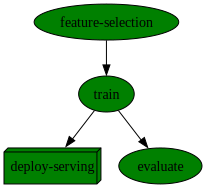

uid,start,state,name,parameters,results
...7d030a5d,Jul 13 17:59:42,completed,evaluate,label_columns=labelmodel=store://artifacts/fraud-demo-pengwei/transaction_fraud_xgboost:4f63a71a-2019-403a-95ea-dba8f6406123drop_columns=label,evaluation_accuracy=0.992503748125937evaluation_f1_score=0.2105263157894737evaluation_precision_score=0.25evaluation_recall_score=0.18181818181818182
...034a6016,Jul 13 17:58:27,completed,train,sample=-1label_column=labeltest_size=0.1,best_iteration=5accuracy=0.992503748125937f1_score=0.2105263157894737precision_score=0.25recall_score=0.18181818181818182
...c6459db2,Jul 13 17:57:43,completed,feature-selection,output_vector_name=shortlabel_column=labelk=18min_votes=2ignore_type_errors=True,top_features_vector=store://feature-vectors/fraud-demo-pengwei/short


In [9]:
run_id = project.run(
    'main',
    arguments={}, 
    dirty=True, watch=True)

<a id="gs-tutorial-4-step-ui-pipeline-view"></a>

## Step 6: Test the model endpoint


Now that your model is deployed using the pipeline, you can invoke it as usual:

In [10]:
# Define your serving function
serving_fn = project.get_function('serving')

# Choose an id for your test
sample_id = 'C1000148617'
model_inference_path = '/v2/models/fraud/infer'

# Send our sample ID for predcition
serving_fn.invoke(path=model_inference_path,
                  body={'inputs': [[sample_id]]})

> 2023-07-13 11:01:29,545 [info] invoking function: {'method': 'POST', 'path': 'http://fraud-demo-pengwei-serving-fraud-demo-pengwei.default-tenant.app.qb-demos.iguazio-cd1.com//v2/models/fraud/infer'}


{'id': '1bcb71c7-eae0-4a28-ab7f-fa91547d2343',
 'model_name': 'fraud',
 'outputs': [0]}

<a id="gs-tutorial-4-done"></a>

## Done!